# Event Count Plots

This notebook create a event count plot based on dbs snapshots. 

*This notebook requires a python 3 kernel and CMSSpark*


This notebook aims to replicate the functionality of [tierstats](https://github.com/vkuznet/tierstats) and the dbs [block list](https://github.com/dmwm/DBS/blob/master/Server/Python/src/dbs/dao/Oracle/Block/BriefList.py) and [blocksummary](https://github.com/dmwm/DBS/blob/master/Server/Python/src/dbs/dao/Oracle/Block/SummaryList.py) API specifically to recreate the plots of events by data tier/month.

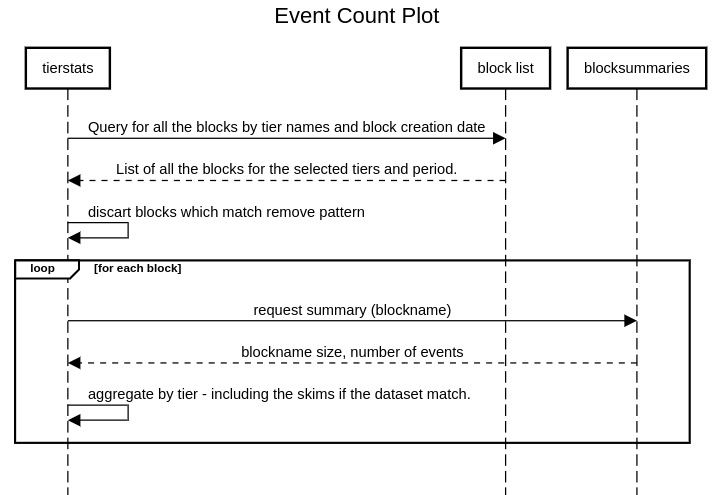

---
To edit the sequence diagram you can use [this link](https://sequencediagram.org/index.html#initialData=C4S2BsFMAIFEDdIDtjQMIHsCuLoAVwNgAoY0SAJwGdgBDYKgWgD4AjQgYwGtpwQaAXNACKWSgE9oAMwwVotcOGjAAFjHYZuVaK0nk5SWgFtI22kgAmOzjw4VI9EBiTQL9SMQ3de-YIxb6NPRUQgAyvtAYUvKKymrWmlzaMnKqMFSQUBzAkFaB8pbQAA6UThYAdGQglEEM0AHV1HQMQhb8HLQUqF5J0ADuKiAcKtBG9MPQ9kYYiMX0ORRIxIQYRdKy0A4TPVU1zUzMCVpYRmMU1SGTkACOYjTQVCdnkgAUPYYmAJS7TcEAPP4eo9Tp0LkJ3sZ0iAAF6QAA00CQJ1YlEi0UgiBQVB+tW0LGUjVxQloAHMSfYSe4dHpGvVoCAkBxwFg2kgSXF0lwQEZtCBomlXPRaBlUGNgMNKsgLKRiEA)

In [1]:
# Environment:
# Add CMSSpark to the python path. Modify this cell to point to your copy of CMSSpark.
import os,sys
sys.path.append(os.path.expanduser('~/wdir/CMSSpark/src/python'))

In [2]:
spark

# Imports

In [3]:
import json
import pandas as pd
import numpy as np
from pyspark.sql.types import StringType
from pyspark.sql.functions import (
    regexp_extract,
    date_format,
    from_unixtime,
    substring_index,
    col,
    input_file_name,
    concat,
    year,
    month,
    lpad,
)
from CMSSpark import spark_utils
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt
import seaborn as sns

## New approach
Using the dbs dumps in HDFS we will replicate the queries using spark. 
The `get_events_by_tier_month` function will:
  - Join the blocks, files and datasets tables, grouping by block name to have a new dataframe with the datablock name, dataset name, data_tier_id, size, creation date, and number of events
  - Add a column with them month in format yyyyMM based on the data block creation date. Filter to have only the desired time range.
  - Join that dataframe with the data_tier table to get the data_tier name; filter by removing the matching dataset names. 
  - The final dataset will be a union of:
      - A dataset grouped by data tier with the total number of events without the datasets that match a skim
      - A dataset grouped by data tier/skim with the total number of events from datasets that match a skim
      

In [4]:
def plot_tiers_month(data):
    """
    Create a stacked bar plot of events by data tier/month. 
    args:
        - data: pandas dataframe with the month, data_tier_name and nevents columns. 
    """
    data_by_month_tier = data
    data_by_month_tier.month = data.month.astype(int)
    fig, ax = plt.subplots(figsize=(20, 7))
    months = pd.DataFrame(
        {"month": pd.Series(data_by_month_tier.month.unique().astype(int), name="month")}
    )
    print(months.dtypes)
    tiers = data_by_month_tier.data_tier_name.unique()
    colors = sns.color_palette("hls", len(tiers))
    totals = (
        data_by_month_tier[["data_tier_name", "nevents"]]
        .groupby("data_tier_name")
        .sum()
        .reset_index()
    )
    totals["nevents"] = totals["nevents"].map("{:,d}".format)
    totals["new_label"] = totals["data_tier_name"].str.cat(
        totals["nevents"].values.astype(str), sep=" nevents: "
    )
    label_replacements = dict(zip(totals.data_tier_name, totals.new_label))
    data_by_month_tier = data_by_month_tier.replace(
        {"data_tier_name": label_replacements}
    )
    pivot_df = data_by_month_tier.pivot(
        index="month", columns="data_tier_name", values="nevents"
    )
    pivot_df.plot.bar(stacked=True, color=colors, ax=ax)
    return fig


def get_events_by_tier_month(
    spark,
    start_date,
    end_date,
    tiers_raw=None,
    skims_raw=None,
    remove_raw=None,
    verbose=False,
):
    """
        Generate a pandas dataframe containing data_tier_name, month, nevents for the given time period.
        It will add virtual tiers based on the skims.
        args:
            - spark: Spark session
            - start_date: String with the date y format yyyy/MM/dd
            - end_date: String with the date y format yyyy/MM/dd
            - tiers_raw: List of tiers
            - remove_raw: List of remove patterns
            - skims_raw: List of skim patterns
            - verbose: True if you want additional output messages, default False. 
            
    """
    if tiers_raw is None:
        tiers_raw = "GEN,GEN-SIM,GEN-RAW,GEN-SIM-RECO,AODSIM,MINIAODSIM,RAWAODSIM".split(
            ","
        )
    if skims_raw is None:
        skims_raw = []
    if remove_raw is None:
        remove_raw = "test,backfill,jobrobot,sam,bunnies,penguins".split(",")
    tiers = "^({})$".format("|".join(["{}".format(tier.strip()) for tier in tiers_raw]))
    skims_rlike = (
        ".*-({})-.*".format("|".join([l.strip() for l in skims_raw]))
        if skims_raw
        else "^$"
    )
    remove_rlike = (
        ".*({}).*".format("|".join([l.strip().lower() for l in remove_raw]))
        if remove_raw
        else "^$"
    )
    tables = spark_utils.dbs_tables(spark, tables=["ddf", "bdf", "fdf", "dtf"])
    if verbose:
        print("remove", remove_rlike)
        print("skims", skims_rlike)
        for k in tables:
            # tables[k].cache()
            print(k)
            tables[k].printSchema()
            tables[k].show(5, truncate=False)
    datablocks_file_events_df = spark.sql(
        """SELECT sum(fdf.f_event_count) as f_event_count, 
                             max(ddf.d_data_tier_id) as d_data_tier_id, 
                             d_dataset, 
                             b_block_name,
                             max(b_creation_date) as b_creation_date,
                             max(b_block_size) as size
                          FROM ddf JOIN bdf on ddf.d_dataset_id = bdf.b_dataset_id 
                                   JOIN fdf on bdf.b_block_id = fdf.f_block_id
                          WHERE d_is_dataset_valid = 1
                          group by d_dataset, b_block_name
                      """
    )
    fiter_field = "b_creation_date"
    datablocks_file_events_df = (
        datablocks_file_events_df.withColumn(fiter_field, from_unixtime(fiter_field))
        .filter(
            fiter_field
            + " between '{}' AND '{}' ".format(
                start_date.replace("/", "-"), end_date.replace("/", "-")
            )
        )
        .withColumn("month", concat(year(fiter_field), lpad(month(fiter_field), 2, "0")))
    )
    datablocks_file_events_df.registerTempTable("dbfe_df")
    # Union of two queries:
    # - The first query will get all the selected data tiers,
    #   excluding the datasets who match the skims
    # - The second query will get all the selected data tiers,
    #   but only the dataset who match the skims.
    grouped = spark.sql(
        """
        select month, data_tier_name, sum(f_event_count) as nevents
        from dbfe_df join dtf on data_tier_id = d_data_tier_id
        where
            data_tier_name rlike '{tiers}'
            and lower(d_dataset) not rlike '{remove}'
            and d_dataset not rlike '{skims}'
            group by month, data_tier_name
        UNION
        select month, 
             concat(data_tier_name, '/',regexp_extract(d_dataset,'{skims}',1)) AS data_tier_name,
             sum(f_event_count) as nevents
        from dbfe_df join dtf on dtf.data_tier_id = d_data_tier_id
        where
            data_tier_name rlike '{tiers}'
            and lower(d_dataset) not rlike '{remove}'
            and d_dataset rlike '{skims}'
            group by month, concat(data_tier_name, '/',regexp_extract(d_dataset,'{skims}',1))
        """.format(
            tiers=tiers, remove=remove_rlike, skims=skims_rlike
        )
    )
    return grouped.toPandas()

# Validation
Running tierstats for 201801 we get:

```
 ./tierstats -trange 20180101-20180131 -tiers RAW,RECO,AOD,RAW-RECO,USER,MINIAOD,NANOAOD -skims PromptReco,Parking -remove test,backfill,StoreResults,monitor,Error/,Scouting,MiniDaq,/Alca,L1Accept,L1EG,L1Jet,L1Mu,PhysicsDST,VdM,/Hcal,express,Interfill,Bunnies,REPLAY,LogError
Final results: time interval 20180101-20180131, 9 records
RAW-RECO            2.935045480257e+12 (2.9TB) 632329 events
MINIAOD             2.435579818587e+13 (24.4TB) 801781125 events
MINIAOD/PromptReco  1.306023762e+09 (1.3GB) 606334 events
NANOAOD             1.204011793614e+12 (1.2TB) 1770353623 events
USER                8.31349723274e+12 (8.3TB) 15970379 events
AOD                 2.2202426793721e+14 (222.0TB) 795534632 events
RAW                 1.537474481276e+12 (1.5TB) 28977257 events
RECO                5.2646834409507e+13 (52.6TB) 22818113 events
AOD/PromptReco      6.689007863e+09 (6.7GB) 1105985 events
```

In [5]:
#parameters
start_date = "2018/01/01"
end_date = "2018/01/31"
tiers_raw = "RAW,RECO,AOD,RAW-RECO,USER,MINIAOD,NANOAOD".split(',')
skims_raw = "PromptReco,Parking".split(',')
remove_raw = "test,backfill,StoreResults,monitor,Error/,Scouting,MiniDaq,/Alca,L1Accept,L1EG,L1Jet,L1Mu,PhysicsDST,VdM,/Hcal,express,Interfill,Bunnies,REPLAY,LogError".split(",")

In [6]:
ddf = get_events_by_tier_month(spark, 
                               start_date,
                               end_date, 
                               tiers_raw=tiers_raw, 
                               remove_raw=remove_raw, 
                               skims_raw=skims_raw, 
                               verbose=False)
test = ddf[ddf.month == "201801"][["data_tier_name", "nevents"]]

Use the following data on HDFS


In [7]:
test["data_tier_name"] = test["data_tier_name"].astype(str)
test["nevents"] = test["nevents"].astype(int)

In [8]:
from io import StringIO
val_data_201801 = """data_tier_name;nevents_tierstats
RAW-RECO;632329
MINIAOD;801781125
MINIAOD/PromptReco;606334
NANOAOD;1770353623
USER;15970379
AOD;795534632
RAW;28977257
RECO;22818113
AOD/PromptReco;1105985
"""
val_df = pd.read_csv(StringIO(val_data_201801), sep=";")

In [9]:
val_df["data_tier_name"] = val_df["data_tier_name"].astype(str)

In [10]:
res = val_df.merge(test, on= "data_tier_name", how='outer')
res.loc[pd.isna(res.nevents), "nevents"] = 0
res["nevents"] = res["nevents"].astype(int)
res["perc_diff"] = (res["nevents_tierstats"] - res["nevents"])/(res["nevents_tierstats"])*100
res

,data_tier_name,nevents_tierstats,nevents,perc_diff
0,RAW-RECO,632329,632329,0.000000
1,MINIAOD,801781125,802612384,-0.103677
2,MINIAOD/PromptReco,606334,606334,0.000000
3,NANOAOD,1770353623,1770353623,0.000000
4,USER,15970379,17108509,-7.126506
5,AOD,795534632,799600693,-0.511110
6,RAW,28977257,28977257,0.000000
7,RECO,22818113,22818113,0.000000
8,AOD/PromptReco,1105985,1105985,0.000000


month    int64
dtype: object


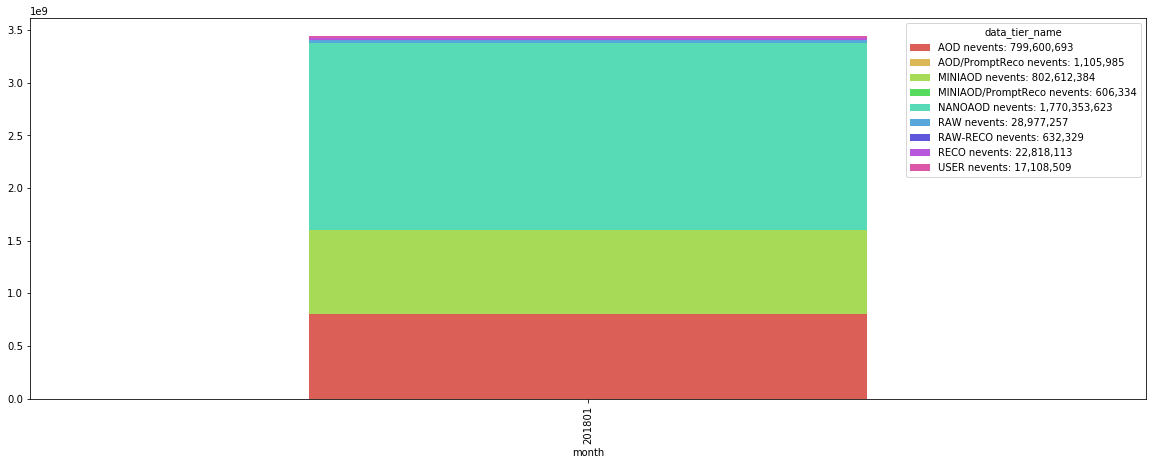

In [11]:
fig = plot_tiers_month(data=ddf)

https://github.com/dmwm/DBS/blob/4207cb6af9df23e2cf789750e3b0e8e2ab4d3050/Server/Python/src/dbs/dao/Oracle/Block/SummaryList.py

```
./tierstats -trange 20180101-20180131 -tiers LHE,GEN,GEN-SIM,GEN-RAW,GEN-SIM-RECO,AODSIM,MINIAODSIM,RAWAODSIM,NANOAODSIM,GEN-SIM-DIGI-RAW,GEN-SIM-RAW,GEN-SIM-DIGI-RECO
Final results: time interval 20180101-20180131, 10 records
LHE                1.6240574376659e+13 (16.2TB) 2019925974 events
MINIAODSIM         1.18201684674605e+14 (118.2TB) 2673558021 events
GEN                1.56162959253e+11 (156.2GB) 5432196 events
AODSIM             9.26556086657078e+14 (926.6TB) 2403371283 events
GEN-SIM-DIGI-RAW   4.73496310519966e+14 (473.5TB) 29294397 events
GEN-SIM-RAW        1.20172391998361e+14 (120.2TB) 211330451 events
GEN-SIM-RECO       1.48914814452276e+14 (148.9TB) 47810265 events
GEN-SIM            8.56757708419943e+14 (856.8TB) 1372006670 events
GEN-SIM-DIGI-RECO  2.3063017533076e+13 (23.1TB) 4376301 events
NANOAODSIM         9.0985649069e+11 (909.9GB) 601767075 events

```


In [12]:
#parameters
start_date = "2018/01/01"
end_date = "2018/01/31"
tiers_raw = "LHE,GEN,GEN-SIM,GEN-RAW,GEN-SIM-RECO,AODSIM,MINIAODSIM,RAWAODSIM,NANOAODSIM,GEN-SIM-DIGI-RAW,GEN-SIM-RAW,GEN-SIM-DIGI-RECO".split(',')
skims_raw = []
remove_raw = []
ddf = get_events_by_tier_month(spark, 
                               start_date,
                               end_date, 
                               tiers_raw=tiers_raw, 
                               remove_raw=remove_raw, 
                               skims_raw=skims_raw, 
                               verbose=False)
test = ddf[ddf.month == "201801"][["data_tier_name", "nevents"]]

Use the following data on HDFS


In [13]:
val_data_201801 = """data_tier_name;nevents_tierstats
LHE;2019925974
MINIAODSIM;2673558021
GEN;5432196
AODSIM;2403371283
GEN-SIM-DIGI-RAW;29294397
GEN-SIM-RAW;211330451
GEN-SIM-RECO;47810265
GEN-SIM;1372006670
GEN-SIM-DIGI-RECO;4376301
NANOAODSIM;601767075"""
val_df = pd.read_csv(StringIO(val_data_201801), sep=";")
val_df["data_tier_name"] = val_df["data_tier_name"].astype(str)
res = val_df.merge(test, on= "data_tier_name", how='outer')
res.loc[pd.isna(res.nevents), "nevents"] = 0
res["nevents"] = res["nevents"].astype(int)
res["perc_diff"] = (res["nevents_tierstats"] - res["nevents"])/(res["nevents_tierstats"])*100
res

,data_tier_name,nevents_tierstats,nevents,perc_diff
0,LHE,2019925974,2020242275,-0.015659
1,MINIAODSIM,2673558021,2675193039,-0.061155
2,GEN,5432196,5432196,0.000000
3,AODSIM,2403371283,2397139860,0.259278
4,GEN-SIM-DIGI-RAW,29294397,29100897,0.660536
5,GEN-SIM-RAW,211330451,211330451,0.000000
6,GEN-SIM-RECO,47810265,57345930,-19.944807
7,GEN-SIM,1372006670,1373227350,-0.088970
8,GEN-SIM-DIGI-RECO,4376301,4476301,-2.285035
9,NANOAODSIM,601767075,601767075,0.000000


# CRSG Plots 

In [14]:
#parameters
start_date = "2018/01/01"
end_date = "2019/01/01"

## Fig 9

Use the following data on HDFS
month    int64
dtype: object


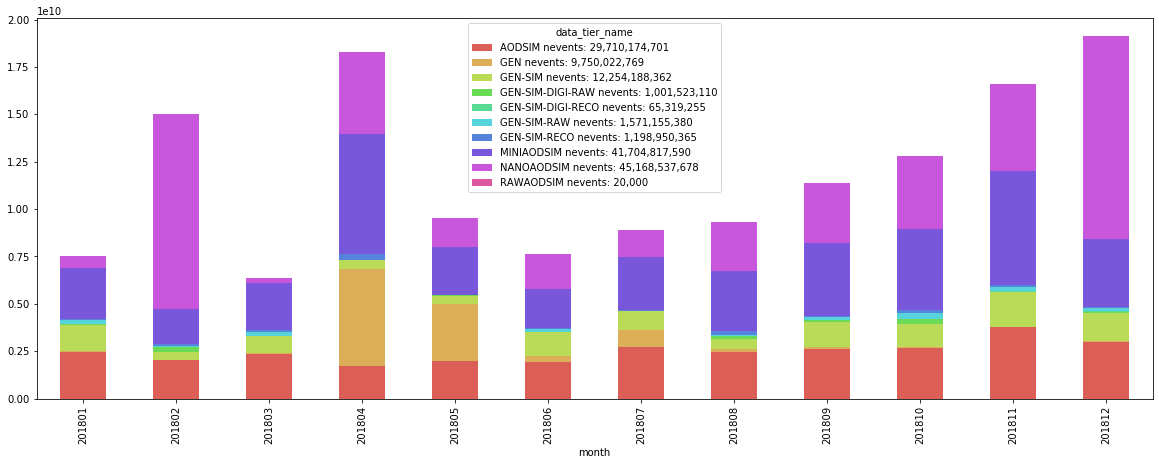

In [15]:
#parameters
tiers_raw = "GEN,GEN-SIM,GEN-RAW,GEN-SIM-RECO,AODSIM,MINIAODSIM,RAWAODSIM,NANOAODSIM,GEN-SIM-DIGI-RAW,GEN-SIM-RAW,GEN-SIM-DIGI-RECO".split(',') #Removing LHE from the query we get a closer result to the one expected. 
skims_raw = []
remove_raw = []

ddf = get_events_by_tier_month(spark, 
                               start_date,
                               end_date, 
                               tiers_raw=tiers_raw, 
                               remove_raw=remove_raw, 
                               skims_raw=skims_raw, 
                               verbose=False)
fig_9 = plot_tiers_month(ddf)

In [16]:
fig_9.savefig("fig09_dbsEventCountPlot_v1.png", format="png")

## Fig 10

Use the following data on HDFS
month    int64
dtype: object


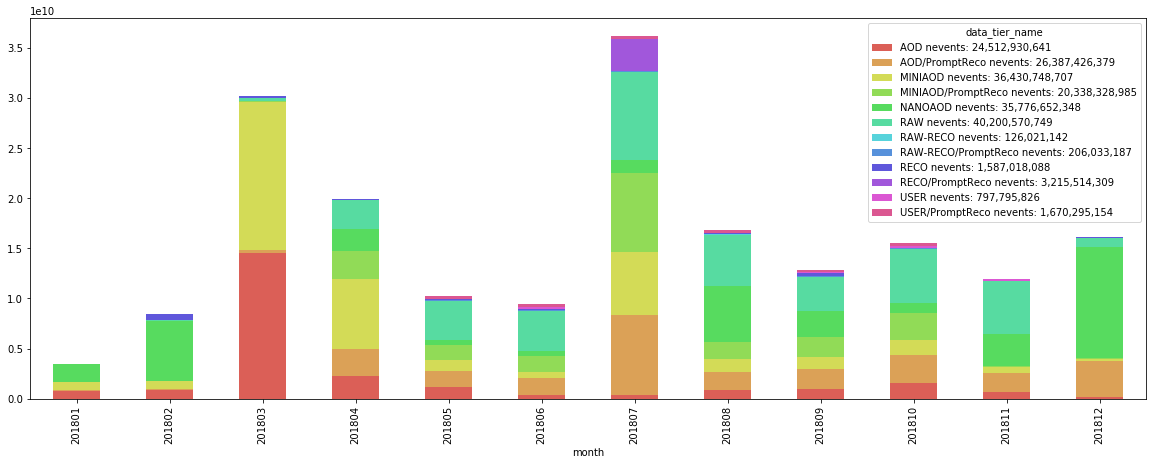

In [17]:
tiers_raw = "RAW,RECO,AOD,RAW-RECO,USER,MINIAOD,NANOAOD".split(',')
skims_raw = "PromptReco,Parking".split(',')
remove_raw = "test,backfill,StoreResults,monitor,Error/,Scouting,MiniDaq,/Alca,L1Accept,L1EG,L1Jet,L1Mu,PhysicsDST,VdM,/Hcal,express,Interfill,Bunnies,REPLAY,LogError".split(",")

ddf = get_events_by_tier_month(spark, 
                               start_date,
                               end_date, 
                               tiers_raw=tiers_raw, 
                               remove_raw=remove_raw, 
                               skims_raw=skims_raw, 
                               verbose=False)
fig_10 = plot_tiers_month(ddf)

In [18]:
fig_10.savefig("fig10_dbsEventCountPlot_v1.png", format="png")

# Aditional experiments

In [19]:
bdf = spark_utils.dbs_tables(spark, tables=["bdf"])["bdf"]

Use the following data on HDFS


In [20]:
bdf.head()

Row(b_block_id=555044, b_block_name='/Cosmics/Commissioning09-v1/RAW#72404277-dfe7-4405-9623-f240b21b60bc', b_dataset_id=13392, b_open_for_writing=0, b_origin_site_name='UNKNOWN', b_block_size=103414137568.0, b_file_count=30, b_creation_date=1236228037.0, b_create_by='/DC=ch/DC=cern/OU=computers/CN=vocms39.cern.ch', b_last_modification_date=1239909571.0, b_last_modified_by='/DC=ch/DC=cern/OU=computers/CN=vocms39.cern.ch')

In [21]:
bdf.groupBy("b_block_name").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|        b_block_name|count|
+--------------------+-----+
|/SingleMuon/Run20...|    1|
|/DM_ScalarZHLL_Mp...|    1|
|/QCD_Pt_300to470_...|    1|
|/JetHT/Run2016C-P...|    1|
|/Neutrino_E-10_gu...|    1|
|/QCD_Pt_300to470_...|    1|
|/StreamExpressCos...|    1|
|/ExpressCosmics/R...|    1|
|/MinimumBias/Run2...|    1|
|/QCD_Inclusive_VB...|    1|
+--------------------+-----+
only showing top 10 rows

